# Part 3 Solutions

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## 3.1

### Simulation Helpers

In [ ]:
from solutions.euler_black_scholes import EulerBlackScholes

# Automatically Orchestrate Multiple Runs

def run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, num_simulations):
    """Run multiple simulations with different hedging frequencies."""
    results = {}
    
    for interval in hedge_intervals:
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating {interval}-day hedging"):
            # Change seed each run
            np.random.seed(200 + i)
            
            # Run a single simulation
            model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
            sim_result = model.delta_hedge_short_call(K, interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[interval] = {
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

In [20]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
sigma = 0.2  # Volatility
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Define hedging intervals to test
hedge_intervals = [1, 5, 21]  # Daily, weekly, and monthly

# Number of simulations
num_simulations = 5000

# Run simulations
results = run_multiple_simulations(S0, K, r, sigma, T, N, hedge_intervals, 
                                    num_simulations)

Simulating 21-day hedging: 100%|██████████| 5000/5000 [00:08<00:00, 614.94it/s]


### Visualisations

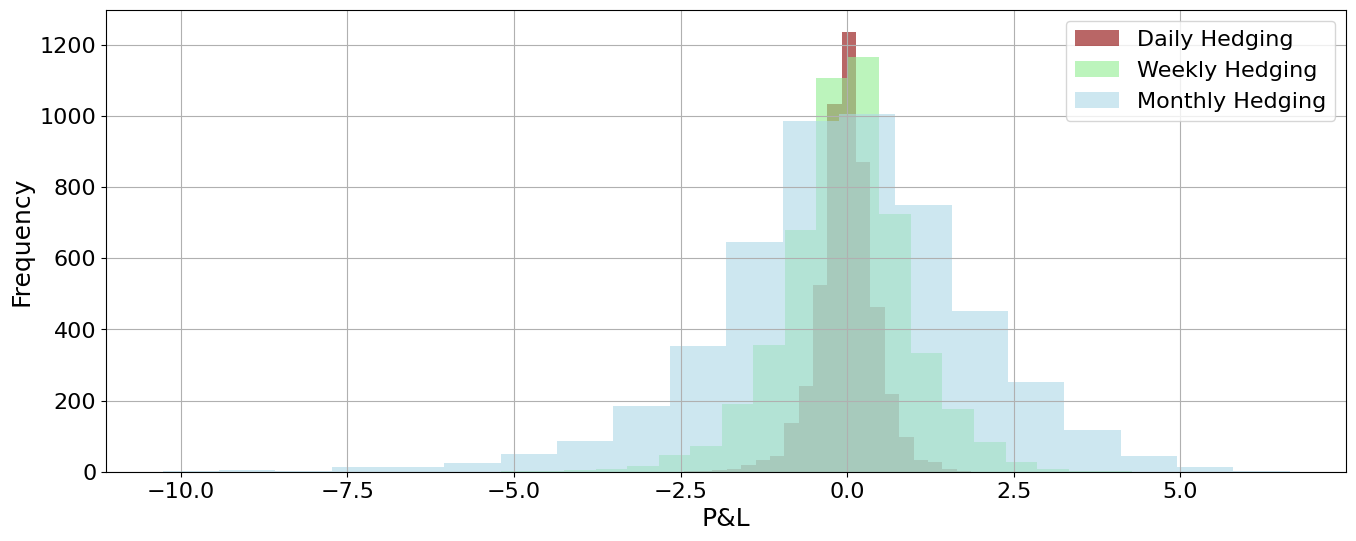

In [28]:
# 1. P&L Distribution Comparison
plt.figure(figsize=(16, 6))
colors = ['darkred', 'lightgreen', 'lightblue']  # Different colors for different frequencies

for i, interval in enumerate(hedge_intervals):
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
        
    plt.hist(results[interval]['all_pnl'], bins=20, alpha=0.6, 
                color=colors[i], label=f"{interval_desc} Hedging")

# plt.title('P&L Distribution by Hedging Frequency', fontsize=18)
plt.xlabel('P&L', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.legend()
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.savefig("figures/p3/pl_distr_by_hedge_freq")
plt.show()

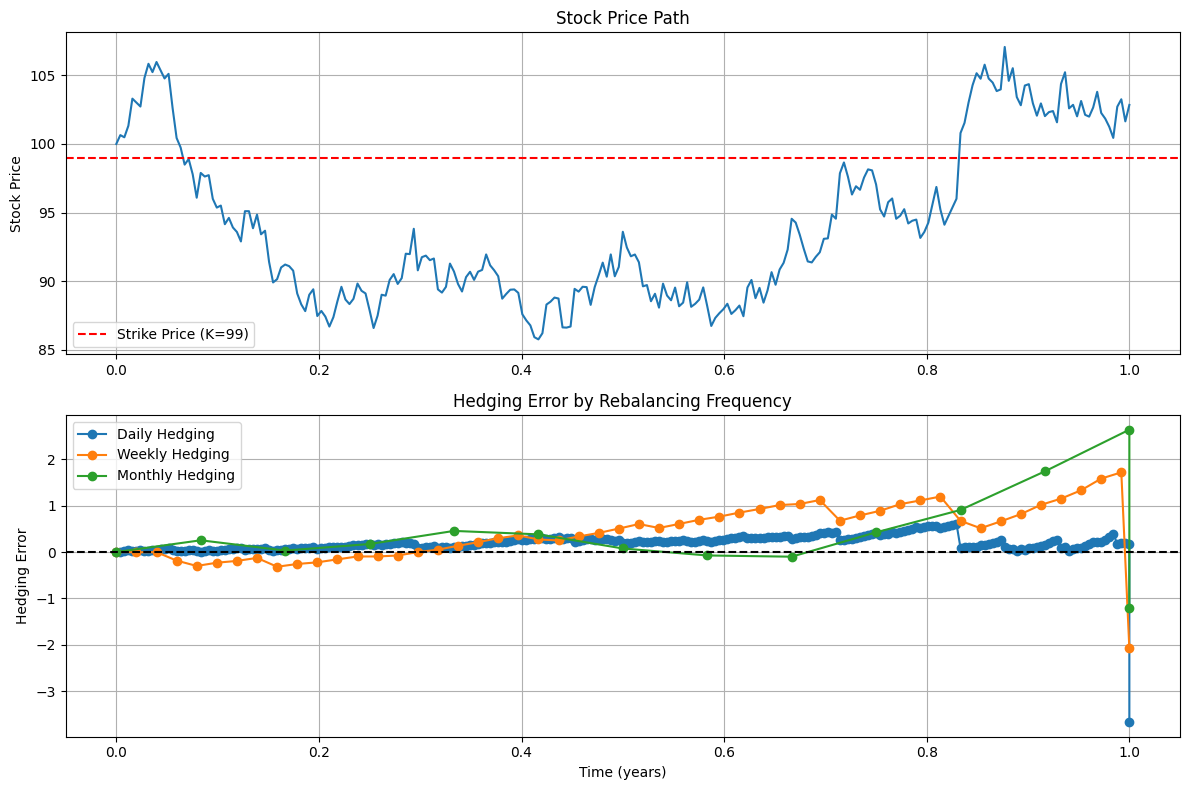

In [5]:
# 2. Single Simulation Analysis with Different Frequencies
plt.figure(figsize=(12, 8))

# Use same seed for all simulations to compare hedging frequency effect on same path
np.random.seed(42)

# Simulate stock path once
model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
time, stock_path = model.simulate()

# Plot stock path
plt.subplot(2, 1, 1)
plt.plot(time, stock_path)
plt.axhline(y=K, color='r', linestyle='--', label=f'Strike Price (K={K})')
plt.title('Stock Price Path')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)

# Plot hedging errors for different frequencies
plt.subplot(2, 1, 2)

for interval in hedge_intervals:
    if interval == 1:
        interval_desc = "Daily"
    elif interval == 5:
        interval_desc = "Weekly"
    elif interval == 21:
        interval_desc = "Monthly"
    else:
        interval_desc = f"{interval}-Day"
    
    # Set same seed to ensure same stock path
    np.random.seed(42)
    model = EulerBlackScholes(S0, r, sigma, sigma, T, N)
    sim = model.delta_hedge_short_call(K, interval)
    
    # Calculate hedging error (portfolio value + option value should ideally be 0)
    # Ensure both arrays have the same length by using the minimum length
    min_length = min(len(sim['portfolio_values']), len(sim['option_values']))
    hedging_error = sim['portfolio_values'][:min_length] - sim['option_values'][:min_length]
    plt.plot(sim['hedge_times'][:min_length], hedging_error, '-o', label=f"{interval_desc} Hedging")

plt.title('Hedging Error by Rebalancing Frequency')
plt.xlabel('Time (years)')
plt.ylabel('Hedging Error')
plt.legend()
plt.grid(True)
plt.axhline(y=0, color='k', linestyle='--')

plt.tight_layout()
plt.savefig("figures/p3/stock_price_path")
plt.show()

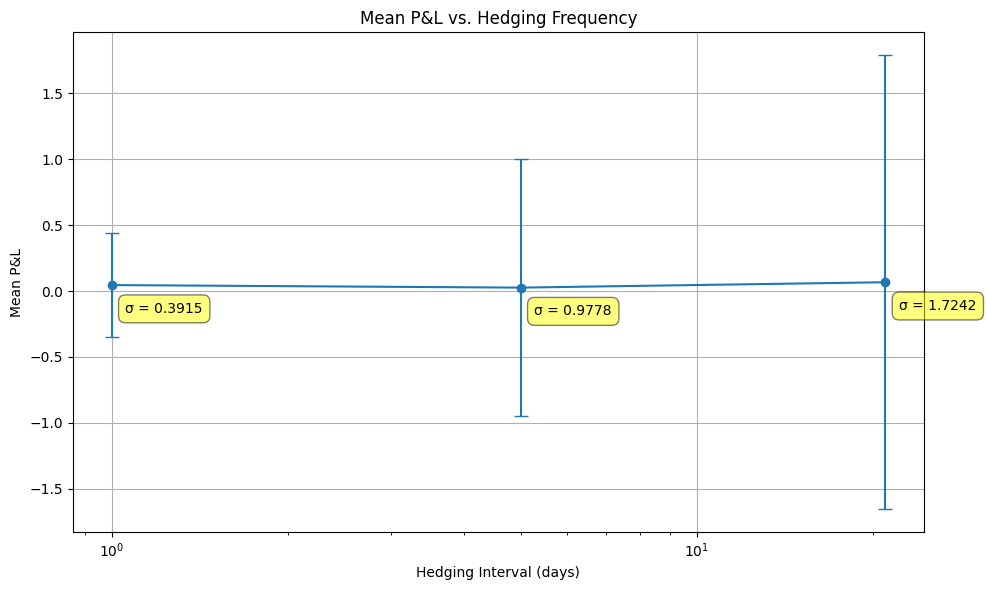

In [6]:
# 3. Scatter plot of P&L vs. Hedging Frequency
plt.figure(figsize=(10, 6))

mean_pnls = [results[interval]['mean_pnl'] for interval in hedge_intervals]
std_pnls = [results[interval]['std_pnl'] for interval in hedge_intervals]

plt.errorbar(hedge_intervals, mean_pnls, yerr=std_pnls, fmt='o-', capsize=5)
plt.xscale('log')
plt.xlabel('Hedging Interval (days)')
plt.ylabel('Mean P&L')
plt.title('Mean P&L vs. Hedging Frequency')
plt.grid(True)

# Add text annotations with standard deviations
for i, interval in enumerate(hedge_intervals):
    plt.annotate(f'σ = {std_pnls[i]:.4f}', 
                (interval, mean_pnls[i]),
                xytext=(10, -20), 
                textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig("figures/p3/mean_pl_vs_hedge_freq")
plt.show()

## 3.2

### Simulation Helpers 

In [7]:
def get_key(vol_true, vol_model):
    return f"true/model [{vol_true:.2f}/{vol_model:.2f}]"

def run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, 
                                        vol_true_list, vol_model_list, num_simulations):
    """
    Run simulations with different combinations of true and model volatilities.
    
    Parameters:
    S0, K, r, T, N : Standard Black-Scholes parameters
    hedge_interval : Frequency of hedging adjustments
    vol_true_list : List of true volatilities for simulation
    vol_model_list : List of model volatilities for pricing/hedging
    num_simulations : Number of simulations for each volatility combination
    
    Returns:
    dict: Results organized by volatility combinations
    """
    results = {}
    
    # Create a meshgrid of all volatility combinations
    from itertools import product
    vol_combinations = list(product(vol_true_list, vol_model_list))
    
    for vol_true, vol_model in vol_combinations:
        key = get_key(vol_true,vol_model)
        
        pnl_values = []
        
        for i in tqdm(range(num_simulations), desc=f"Simulating for {key}"):
            # Set a different seed for each simulation
            np.random.seed(i)
            
            # Create model and run simulation
            model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
            sim_result = model.delta_hedge_short_call(K, hedge_interval)
            pnl_values.append(sim_result['final_pnl'])
        
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'mean_pnl': np.mean(pnl_values),
            'std_pnl': np.std(pnl_values),
            'min_pnl': np.min(pnl_values),
            'max_pnl': np.max(pnl_values),
            'all_pnl': pnl_values
        }
    
    return results

def analyze_single_path(S0, K, r, T, N, hedge_interval, vol_true, vol_model_list):
    """Analyze a single price path with different model volatilities."""
    results = {}
    
    # Generate one price path with the true volatility
    np.random.seed(42)  # For reproducibility
    base_model = EulerBlackScholes(S0, r, vol_true, vol_true, T, N)
    time, S = base_model.simulate()
    
    # Use this same path with different model volatilities
    for vol_model in vol_model_list:
        model = EulerBlackScholes(S0, r, vol_true, vol_model, T, N)
        
        # Override the simulate method to use our pre-generated path
        original_simulate = model.simulate
        model.simulate = lambda: (time, S)
        
        # Run the hedging simulation
        sim_result = model.delta_hedge_short_call(K, hedge_interval)
        
        # Store results
        key = get_key(vol_true,vol_model)
        results[key] = {
            'true_vol': vol_true,
            'model_vol': vol_model,
            'final_pnl': sim_result['final_pnl'],
            'portfolio_values': sim_result['portfolio_values'],
            'option_values': sim_result['option_values'],
            'delta_values': sim_result['delta_values'],
            'hedge_times': sim_result['hedge_times']
        }
        
        # Restore original method
        model.simulate = original_simulate
    
    return time, S, results

In [8]:
# Setup and Run the Simulations
S0 = 100  # Initial stock price
K = 99    # Strike price
r = 0.06  # Risk-free rate
T = 1.0   # Time to maturity (years)
N = 252   # Number of time steps (trading days in a year)

# Hedging frequency
hedge_interval = 5  # Weekly hedging

# Volatility lists to test
vol_true_list = [0.10, 0.20, 0.30]  # True volatilities
vol_model_list = [0.10, 0.20, 0.30]  # Model volatilities

# Number of simulations
num_simulations = 100

# 1. Run simulations with different volatility combinations
results = run_volatility_mismatch_simulations(S0, K, r, T, N, hedge_interval, 
                                            vol_true_list, vol_model_list, num_simulations)

Simulating for true/model [0.30/0.30]: 100%|██████████| 100/100 [00:01<00:00, 53.84it/s]


### Visualisations

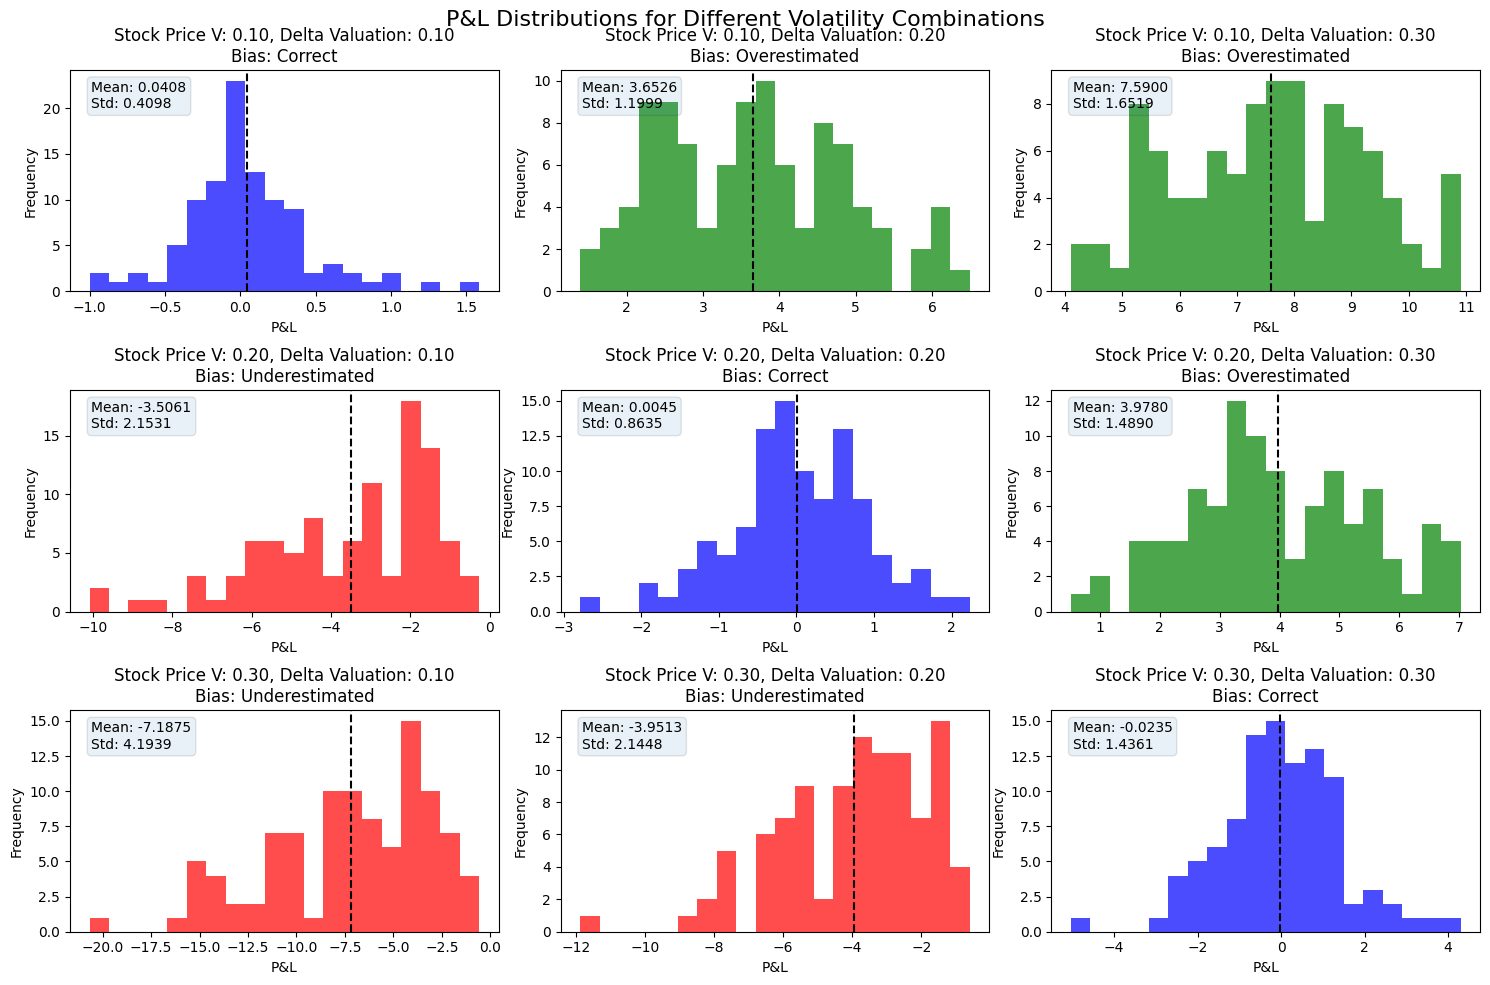

In [9]:
# 1. Visualize P&L distributions for different volatility combinations
plt.figure(figsize=(15, 10))


# Create a grid for subplots - one row for each true volatility
num_true_vols = len(vol_true_list)
num_model_vols = len(vol_model_list)

for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true,vol_model)
        
        # Create subplot
        plt.subplot(num_true_vols, num_model_vols, i*num_model_vols + j + 1)
        
        # Calculate hedging bias
        bias = vol_model - vol_true
        bias_text = "Overestimated" if bias > 0 else "Underestimated" if bias < 0 else "Correct"
        
        # Plot histogram of P&L
        plt.hist(results[key]['all_pnl'], bins=20, alpha=0.7, 
                color='blue' if bias == 0 else 'red' if bias < 0 else 'green')
        
        plt.title(f"Stock Price V: {vol_true:.2f}, Delta Valuation: {vol_model:.2f}\nBias: {bias_text}")
        plt.axvline(results[key]['mean_pnl'], color='k', linestyle='--')
        
        plt.xlabel('P&L')
        plt.ylabel('Frequency')
        
        # Add mean and std as text
        plt.text(0.05, 0.95, f"Mean: {results[key]['mean_pnl']:.4f}\nStd: {results[key]['std_pnl']:.4f}", 
                transform=plt.gca().transAxes, va='top', bbox=dict(boxstyle='round', alpha=0.1))

plt.tight_layout()
plt.suptitle('P&L Distributions for Different Volatility Combinations', fontsize=16)
plt.subplots_adjust(top=0.92)

plt.savefig("figures/p3/pl_for_diff_volatility_combos")
plt.show()

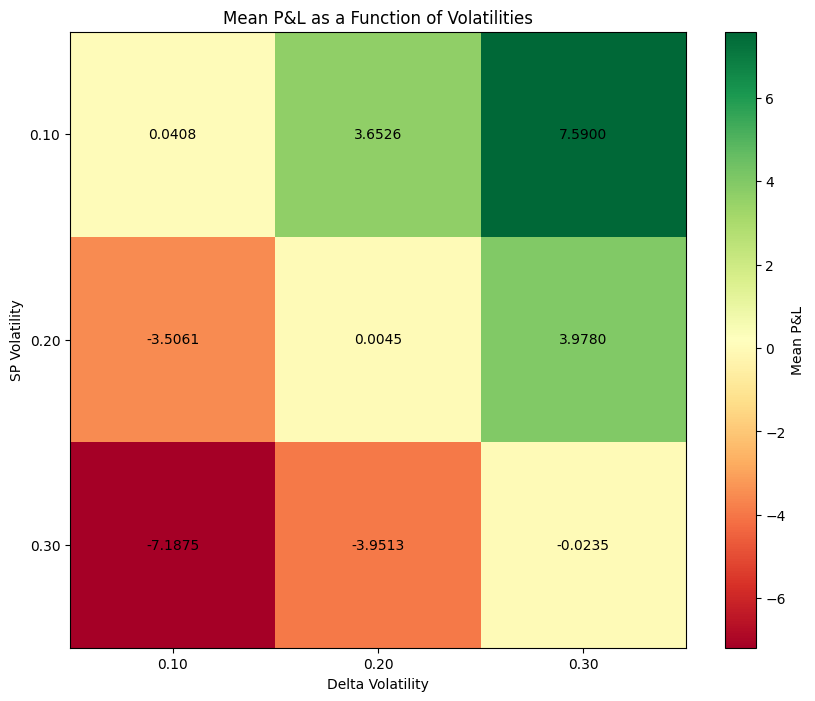

In [10]:
# 3. Heat map of mean P&L
plt.figure(figsize=(10, 8))

# Prepare data for heatmap
heatmap_data = np.zeros((len(vol_true_list), len(vol_model_list)))
for i, vol_true in enumerate(vol_true_list):
    for j, vol_model in enumerate(vol_model_list):
        key = get_key(vol_true,vol_model)
        heatmap_data[i, j] = results[key]['mean_pnl']

# Create heatmap
plt.imshow(heatmap_data, cmap='RdYlGn', interpolation='nearest')
plt.colorbar(label='Mean P&L')

# Set labels
plt.xticks(np.arange(len(vol_model_list)), [f"{v:.2f}" for v in vol_model_list])
plt.yticks(np.arange(len(vol_true_list)), [f"{v:.2f}" for v in vol_true_list])
plt.xlabel('Delta Volatility')
plt.ylabel('SP Volatility')
plt.title('Mean P&L as a Function of Volatilities')

# Add text annotations
for i in range(len(vol_true_list)):
    for j in range(len(vol_model_list)):
        plt.text(j, i, f"{heatmap_data[i, j]:.4f}", 
                ha="center", va="center", color="black")

plt.savefig("figures/p3/mean_pl_volatilities")
plt.show()

##